In [1]:
import numpy as np
import torch
import torch.nn as nn
import sys
sys.path.append("../../")
from vi_rnn.vae import VAE
from vi_rnn.train import train_VAE
from torch.utils.data import DataLoader
from vi_rnn.datasets import Reaching, Reaching_Teacher
from py_rnn.model import RNN, predict
from py_rnn.train import train_rnn
from py_rnn.train import save_rnn, load_rnn
from vi_rnn.utils import *
import matplotlib.pyplot as plt
from vi_rnn.saving import save_model, load_model
from py_rnn.default_params import get_default_params

%matplotlib inline

In [2]:
train_teacher = False  # load already trained teacher model
data_dir = "../../data/student_teacher/"  # store inferred model
model_dir = "../../models/students/"  # store teacher RNN
cuda = True  # toggle if GPU is available

In [3]:
# initialise teacher RNN
model_params, training_params = get_default_params(n_rec=60)
training_params["n_epochs"] = 5000
training_params["l2_rates_reg"] = 0.1
rnn_reach = RNN(model_params)

# initialise teacher RNN's task
task_params_teacher = {
    "onset": [25, 26],  # time till target stimulus onset (uniform between)
    "trial_len": 150,  # trial duration
    "stim_dur": [25, 26],  # target stimulus duration
    "n_stim": 8,  # number of stimuli locations
}
reaching = Reaching(task_params_teacher)
stimulus, target, loss_mask = reaching[1]

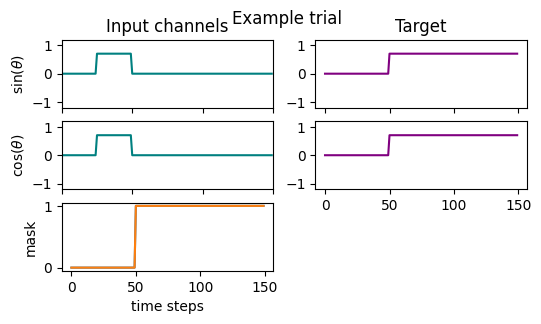

In [4]:
# Plot an example trial for teacher RNN
fig, axs = plt.subplots(3, 2, figsize=(6, 3))
fig.suptitle("Example trial")
axs[0, 0].set_title("Input channels")
axs[0, 1].set_title("Target")
axs[0, 0].set_ylabel(r"$\sin(\theta)$")
axs[1, 0].set_ylabel(r"$\cos(\theta)$")
axs[2, 0].set_ylabel("mask")

for i in range(2):
    axs[i, 0].plot(stimulus[:, i], color="teal")
    axs[i, 0].set_xlim(0, task_params_teacher["trial_len"])
    axs[i, 0].set_ylim(-1.2, 1.2)
axs[2, 0].plot(loss_mask)
for i in range(2):
    axs[i, 1].plot(target[:, i], color="purple")
    axs[i, 0].set_xlim(0, task_params_teacher["trial_len"])
    axs[i, 1].set_ylim(-1.2, 1.2)
    axs[i, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[2, 1].set_xlabel("time steps")
axs[2, 0].set_xlabel("time steps")
fig.delaxes(axs[2, 1])

In [5]:
# train or load teacher RNN
if train_teacher:
    losses, reg_losses = train_rnn(
        rnn_reach, training_params, reaching, sync_wandb=False
    )
    save_rnn(
        data_dir + "reach_rnn_new",
        rnn_reach,
        model_params,
        task_params_teacher,
        training_params,
    )
else:
    rnn_reach, model_params, task_params_teacher, training_params = load_rnn(
        data_dir + "reach_rnn"
    )

/home/matthijs/smc_rnns/train_scripts/student_teacher/../../py_rnn/train.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_fi

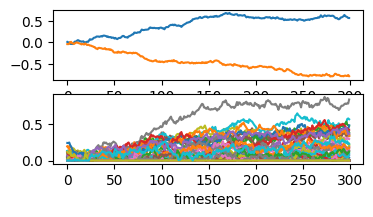

In [6]:
# plot example output
rates, pred = predict(rnn_reach, torch.zeros(300, 2))
fig, axs = plt.subplots(2, figsize=(4, 2))
axs[0].plot(pred[0, :, :])
axs[1].set_xlabel("timesteps")
axs[1].plot(rnn_reach.rnn.nonlinearity(torch.from_numpy(rates[0])));

In [7]:
# Extract weights
U, V, B = extract_orth_basis_rnn(rnn_reach)
I = rnn_reach.rnn.w_inp.detach()

In [8]:
# Generate data using teacher RNN, used for training student RNN
task_params = {
    "dur": 250,
    "n_trials":800,
    "name": "Sine",
    "n_neurons": rnn_reach.rnn.N,
    "out": "currents",
    "w": 0.1,
    "R_x": 0.05,
    "R_z": 0.05,
    "r0":0, 
    "sim_v":False,
    "non_lin": nn.ReLU(),
}
task_params_teacher["trial_len"] = task_params["dur"]
task = Reaching_Teacher(task_params, task_params_teacher, U, V, B, I, decay=0.9)


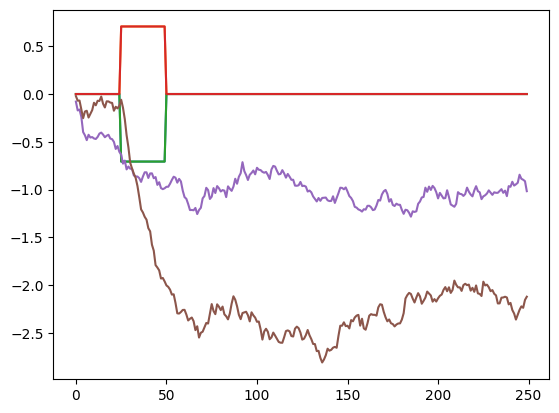

In [9]:
ti= 3
plt.plot(task.stim[ti,:,:])
plt.plot(task.v[ti,:,:])
plt.plot(task.latents[:,ti,:].T)


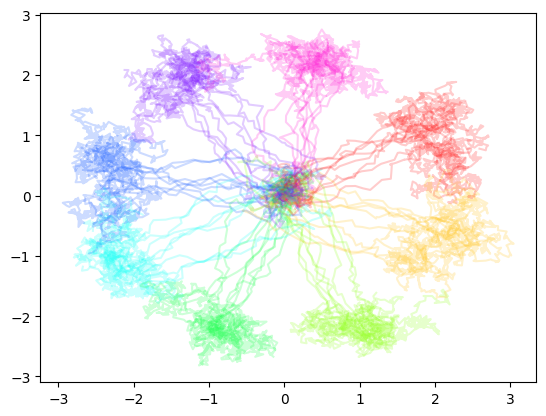

In [10]:
# Plot example latents of teacher RNN
fig,ax = plt.subplots()
prop_cycle = [plt.cm.hsv(i) for i in np.arange(0, 1, 1 / 8)]
ax.set_prop_cycle("color", prop_cycle)
for tr_i in range(8*8):
    latent_code = task.latents[:, tr_i]
    stim = task.stim[tr_i]
    ax.plot(latent_code[0], latent_code[1], alpha=.2)
    ax.scatter(stim[50, 0], stim[50, 1])

In [11]:
# Initialise VI / student setup

dim_z = 2
dim_N = task_params["n_neurons"]
dim_x = task_params["n_neurons"]
dim_u = 2
bs = 10
cuda = True
n_epochs = 200
wandb = False
# initialise encoder
enc_params = {"obs_grad": True, "init_scale": 0.1}

# initialise prior
prior_params = {
    "train_noise_x": True,
    "train_noise_z": True,
    "train_noise_z_t0": True,
    "init_noise_z": 0.1,
    "init_noise_z_t0": 1,
    "init_noise_x": 0.1,
    "scalar_noise_z": "Cov",
    "scalar_noise_x": False,
    "scalar_noise_z_t0": "Cov",
    "identity_readout": True,
    "activation": "relu",
    "exp_par": True,
    "shared_tau": 0.7,
    "readout_from": task_params["out"],
    "train_obs_bias": False,
    "train_obs_weights": False,
    "train_latent_bias": False,
    "train_neuron_bias": True,
    "orth": False,
    "m_norm": False,
    "weight_dist": "uniform",
    "weight_scaler": 1,  # /dim_N,
    "initial_state": "trainable",
    "out_nonlinearity": "identity"
}


training_params = {
    "lr": 1e-3,
    "lr_end": 1e-5,
    "opt_eps": 1e-8,
    "n_epochs": n_epochs,
    "grad_norm": 0,
    "bootstrap": False,
    "eval_epochs": 50,
    "batch_size": bs,
    "cuda": cuda,
    "smoothing": 20,
    "freq_cut_off": 10000,
    "sim_obs_noise": 0,
    "sim_latent_noise": 1,
    "k": 64,
    "loss_f": "opt_VGTF",
    "resample": "systematic",  # , multinomial or none"
    "run_eval": False,
    "smooth_at_eval": False,
    "sim_v":task_params['sim_v'],
}


VAE_params = {
    "dim_x": dim_x,
    "dim_z": dim_z,
    "dim_u": dim_u,
    "dim_N": dim_N,
    "enc_architecture": "Inv_Obs",
    "enc_params": enc_params,
    "prior_architecture": "PLRNN",
    "prior_params": prior_params,
}
vae = VAE(VAE_params)

using ReLU activation
using uniform init
weight scaler 1


In [13]:
vae, vae_params, task_params, training_params = load_model(model_dir + "reach_vae_new2")

using ReLU activation
using uniform init
weight scaler 1


/home/matthijs/smc_rnns/train_scripts/student_teacher/../../vi_rnn/saving.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(state_dict_file_rnn, map_locat

In [14]:
training_params['lr'] = 1e-5
training_params['lr_end'] = 1e-6

In [15]:
# Train
train_VAE(
    vae,
    training_params,
    task,
    sync_wandb=wandb,
    out_dir=model_dir[:-1],
    fname=None,
    store_train_stats=False,
)

Training on : cuda
Learning rate decay factor 0.9885530946569389
epoch 1 loss: -93.6371, ll: 93.6371, ll_x: -94.7274, ll_z: -4.4204 H: 5.3466, alpha: 0.26, lr: 0.000010, N_z: 0.0280, N_x: 0.0500
epoch 2 loss: -93.6386, ll: 93.6386, ll_x: -94.7288, ll_z: -4.4202 H: 5.3466, alpha: 0.26, lr: 0.000010, N_z: 0.0280, N_x: 0.0500
epoch 3 loss: -93.6399, ll: 93.6399, ll_x: -94.7292, ll_z: -4.4208 H: 5.3468, alpha: 0.26, lr: 0.000010, N_z: 0.0280, N_x: 0.0500
epoch 4 loss: -93.6412, ll: 93.6412, ll_x: -94.7308, ll_z: -4.4207 H: 5.3468, alpha: 0.26, lr: 0.000010, N_z: 0.0280, N_x: 0.0500
epoch 5 loss: -93.6419, ll: 93.6419, ll_x: -94.7315, ll_z: -4.4207 H: 5.3469, alpha: 0.26, lr: 0.000010, N_z: 0.0280, N_x: 0.0500
epoch 6 loss: -93.6424, ll: 93.6424, ll_x: -94.7316, ll_z: -4.4207 H: 5.3465, alpha: 0.26, lr: 0.000009, N_z: 0.0280, N_x: 0.0500
epoch 7 loss: -93.6435, ll: 93.6435, ll_x: -94.7325, ll_z: -4.4212 H: 5.3470, alpha: 0.26, lr: 0.000009, N_z: 0.0280, N_x: 0.0500
epoch 8 loss: -93.6431, l

KeyboardInterrupt: 

In [19]:
save_model(vae, training_params, task_params, name=model_dir + "reach_vae_new2")

'../../models/students/reach_vae_new2'